# kaggle: Bike Sharing Demand

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from preprocessing_tools import basic_encode
from IPython.core.display import display, HTML

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 180)
pd.set_option('display.width', 180)

PATH = '/home/piotr/repo/bikes'
train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))
data = train
#print("da")
display(HTML('<h2>Typy danych</h2>'))
print(data.dtypes)
display(HTML('<h2>Czy dane są dziurawe? (tzn. czy są jakieś np.nan?)</h2>'))
print(data.isnull().any().any())
data = basic_encode(data)

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object


False


# W jaki sposób pogoda wpływa na rowerzystów?

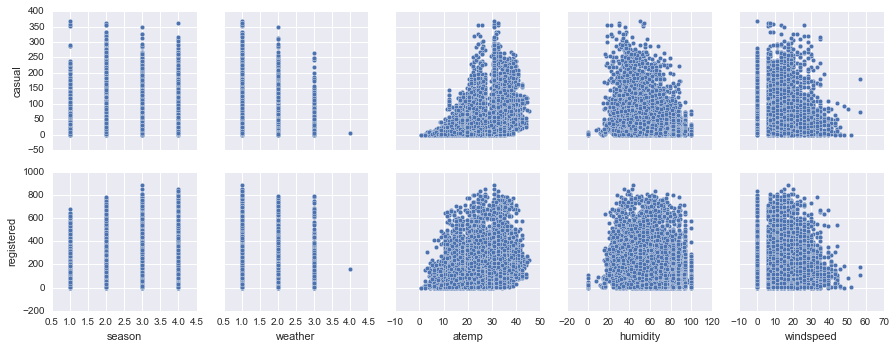

In [2]:
sns.pairplot(data, 
             kind="scatter",
             y_vars=['casual', 'registered'], 
             x_vars=['season', 'weather', 'atemp', 'humidity', 'windspeed']) 
plt.show()

*  Generalnie więcej wypożyczeń dokonują zarejestrowani użytkownicy.
*  Zarejestrowani rowerzyści nie boją się też złej pogody.
 *  Nie zarejestrowani cykliści mniej chętnie wypożyczają rowery kiedy jest zimno, wilgotno lub pada deszcz. Wśród zarejestrowanych cyklistów ten trend jest dużo słabszy. 

#  Jak trendy godzinowe różnią się dla wolnych i pracujących dni?

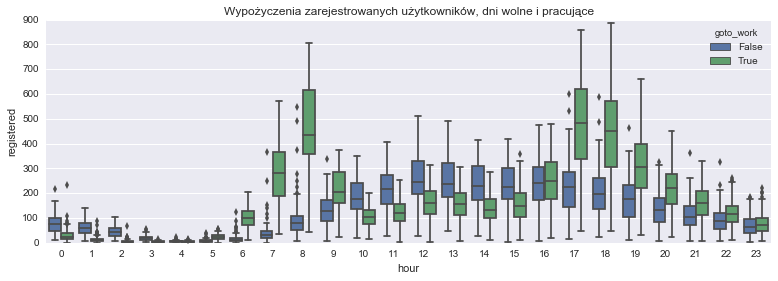

In [3]:
data['goto_work'] = data['workingday'] & (data['holiday'] == 0)

rcParams['figure.figsize'] = 13, 4
plt.title('Wypożyczenia zarejestrowanych użytkowników, dni wolne i pracujące')
sns.boxplot(data=data, 
            x="hour", y="registered", hue='goto_work')
plt.show()

* Dla zarejestrowanych cyklistów widać dwa schematy dziennych wypożyczeń.
 *  W dni pracujące widoczny jest wzrost wypożyczeń w okresie jazdy "do pracy" i "z pracy".
 *  W dni wolne zarejestrowani cykliści decydują się na popołudniowe wycieczki. 

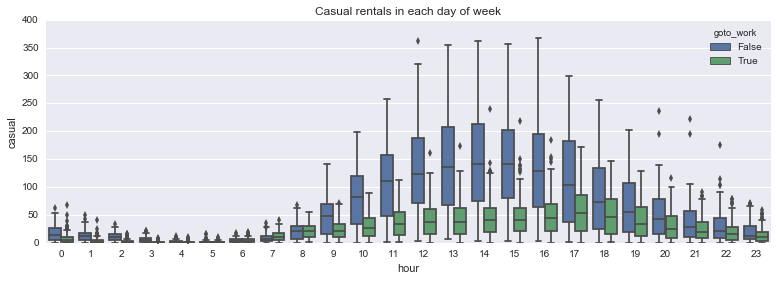

In [4]:
plt.title('Wypożyczenia nie zarejestrowanych użytkowników, dni wolne i pracujące')
sns.boxplot(data=data, 
            x="hour", y="casual", hue='goto_work')
plt.show()

* W przeciwieństwie do wypożyczeń dokonywanych przez zarejestrowanych użytkowników, wypożyczeń doraźnych jest znacznie więcej w dni wolne od pracy.
* Również niedzielni cykliści preferują wycieczki popołudniowe. 

# Artefakty

Na niektórych wykresach widoczne są artefakty: Na wykresie temperatury (~20 i 30 stopni) i na wykresie prędkości wiatru (między 0 a 10 km/h).
Zobaczmy jak wyglądają rozkłady tych cech:

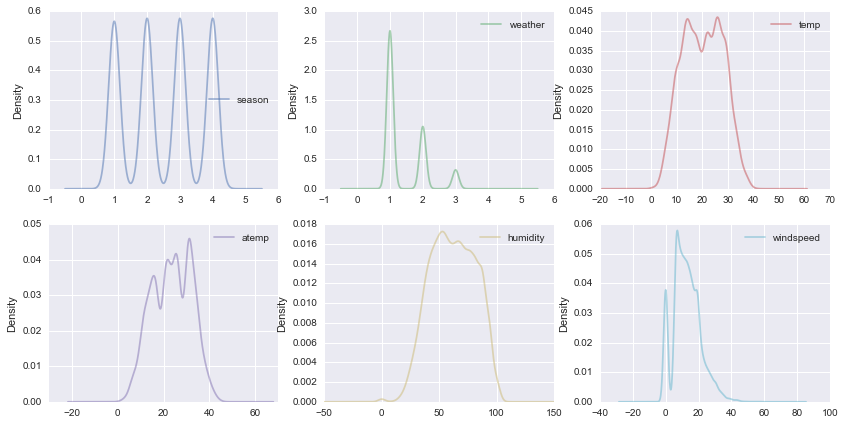

In [5]:
to_dist = data[['season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']]
to_dist.plot.kde(alpha=0.5, figsize=(14, 7), subplots=True, sharex=False, sharey=False, layout=(2, 3))
plt.show()

Te same artefakty widoczne są na rozkładach cech nie zależnie od liczby wypożyczeń, więc nie są interesujące dla z punktu widzenia naszego problemu.

# Trendy dzienne

*Czy dziś o 14 będzie mniej-więcej tyle wyożyczeń co wczoraj o 14? Mniej-więcej tyle co tydzień temu 14?*

Ilości wypożyczeń, o godzinie 8 i 14, w kolejnych dniach w całym okresie zawartym w danych. "Dziury" na wykresie to miejsca do wypełnienia przez klasyfikator.

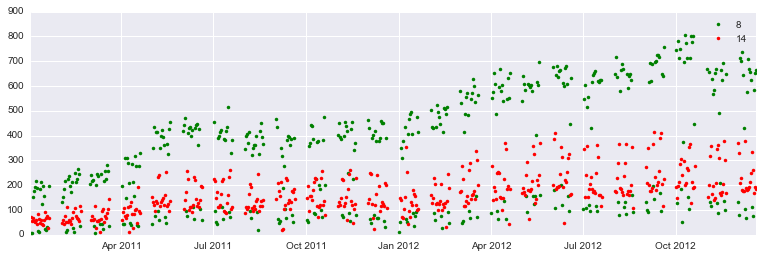

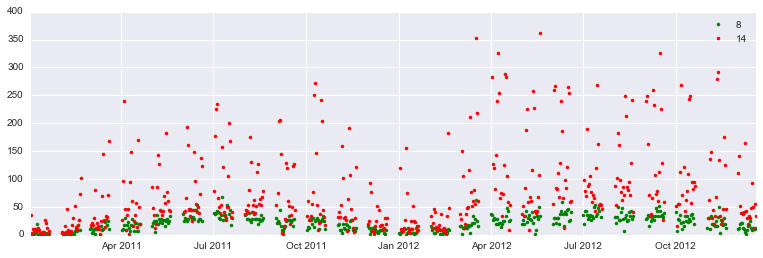

In [7]:
data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], req='h'))
rcParams['figure.figsize'] = 13, 4
display(HTML('<h3>Zarejestrowani</h3>'))
for hour, style in [(8, 'g.'), (14, 'r.')]:
    s = data[data['hour'] == hour]
    plt.plot(s.index, s['registered'], style, label=str(hour))
plt.legend()
plt.show()

display(HTML('<h3>Nie zarejestrowani</h3>'))
for hour, style in [(8, 'g.'), (14, 'r.')]:
    s = data[data['hour'] == hour]
    plt.plot(s.index, s['casual'], style, label=str(hour))
plt.legend()
plt.show()

# Aplikowanie klasyfikatora

Wykres prezentuje ilość wszystkich wypożyczeń o godzinie 14 w całym okresie zawartym w danych. Niebieskie punkty pochodzą z estymatora. 

/home/piotr/.virtualenvs/tf/lib/python3.5/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/piotr/.virtualenvs/tf/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


saving


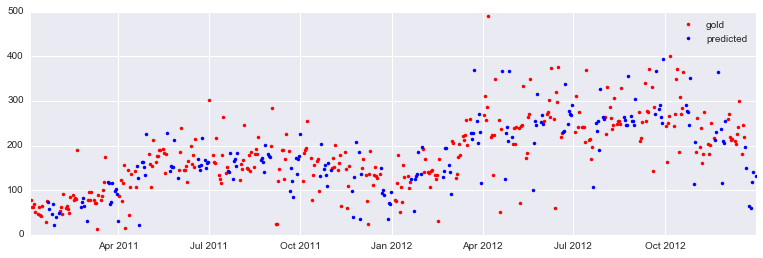

done


In [2]:
from random_forest_regressor import find_best_params, classify_test_set

params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_jobs': 7,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
#find_best_params(500)

#rcParams['figure.figsize'] = 10, 5
rcParams['figure.figsize'] = 13, 4
classify_test_set(7000, False, params)
print("done")

# Algorytm

## Klasyfikator

Zwyczaje zarejestrowanych użytkowników znacznie różnią się od zwyczajów użytkowników nie zarejestrowanych. Dlatego wytrenowałem dwa oddzielne klasyfikatory. Przetestowałem następujące algorytmy:

 *  Linear Regressor (sklearn)
 *  Random Forest Regressor (sklearn)
 *  Gassian Process Regressor (sklearn, radial kernel)
 *  Deep neural network (tensorflow)

Spośród nich Random Forest dawał najlepsze wyniki w kroswalidacji i ten klasyfikator zastosowałem do wygenerowania ostatecznej odpowiedzi. 

## Cechy i pre-processing 

Do cech zawartych w danych dodałem:

 *  Rok - uzyskany z pola datatime. Ponieważ dane obejmują tylko dwa lata, zastosowałem kodowanie one-hot.
 *  Dzien tygodnia - uzyskany z pola datetime, zapisany jako int.
 *  Godzina - uzyskana z pola datetime, zakodowana jako int.
 *  Dzień wolny - kombinacja workingday==0 i holidays==1 i dey_of_week in [5, 6]. Dodałem tę cechę, ponieważ była mi potrzebna do rysowania wykresów. Drzewo decyzyjne powinno taki warunek wykryć samo. 

Zmienne season i weather zakodowałem one-hot.


W pracy [1] dodano jeszcze wyspecjalizowane cechy:
 
 * Wskazujące sprzyjającą pogodę, temperaturę i wiatr do jazdy na rowerze. 
 * Wskazującą okresy czasu 'do pracy', 'z pracy' i 'środek dnia'

Przetestowałem te cechy, jednak nie poprawiały wyników systemu w kroswalidacji. Nie użyłem ich w końcowym rozwiązaniu. 

Z transformacji zaproponowanych w [1] wykorzystałem pomysł zastosowania klasyfikacji dla logarytmów liczy wypożyczeń, zamiast dla liczby wypożyczeń bezpośrednio.  
 
### Inne przekształcenia
   
Dodatkowo przy testach regresji liniowej i sieci neuronowych, znormalizowałem wszystkie cechy ustawiając ich średnie na 0 i wariancje na 1. 
W przypadku sieci neuronowej eksperymentowałem z kodowaniem one-hot dla wszystkich nieciągłych cech. Żaden z tych zabiegów nie doprowadził jednak do lepszych wyników 
niż te uzyskane przez random forest.


## Kroswalidacja

Sposób, w jaki udostępnione zostały dane utrudnia kroswalidację. Dane zaprezentowano w układzie godzinowym, jednak podział na zbiór treningowy i testowy nie jest przypadkowy. Z każdego miesiąca pierwsze 19 dni znajduje się w zbiorze treningowym, a pozostałe dni w zbiorze testowym. 

Żeby przybliżyć tę procedurę, dokonywałem podziału na zbiór testowy i walidacyjny na poziomie dni, a nie pojedynczych rekordów. 



# Wyniki

W kroswalidacji z 10 podziałami system uzyskał następujące wyniki:

**0.1297** na zbiorze treningowym.

**0.3843** (błąd standardowy 0.0231) na zbiorze walidacyjnym

Zbiór testowy (oceniony przez Kagle): **0.39586**

Kody źródłowe oraz plik .csv z ostatecznym załączam dostępne są razem z tym dokumentem.

# Referencje
*  [1] https://www.analyticsvidhya.com/blog/2015/06/solution-kaggle-competition-bike-sharing-demand/
*  [2] http://scikit-learn.org/stable/
*  [3] https://www.tensorflow.org/